#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Импорт библиотек

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import os
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor

## Подготовка

In [2]:
data_path = 'datasets'
st = 12345
warnings.filterwarnings('ignore')                   

In [3]:
data = pd.read_csv(os.path.join(data_path, 'taxi.csv'), parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Загрузил временной ряд.

In [4]:
data.shape

(26496, 1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропущенных значений нет, всего 26494 значений.

In [6]:
data.sort_index(inplace=True)
print(data.index.is_monotonic_increasing)

True


Отсортировал значения по хронологии.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выполнил ресемплирование по 1 часу.

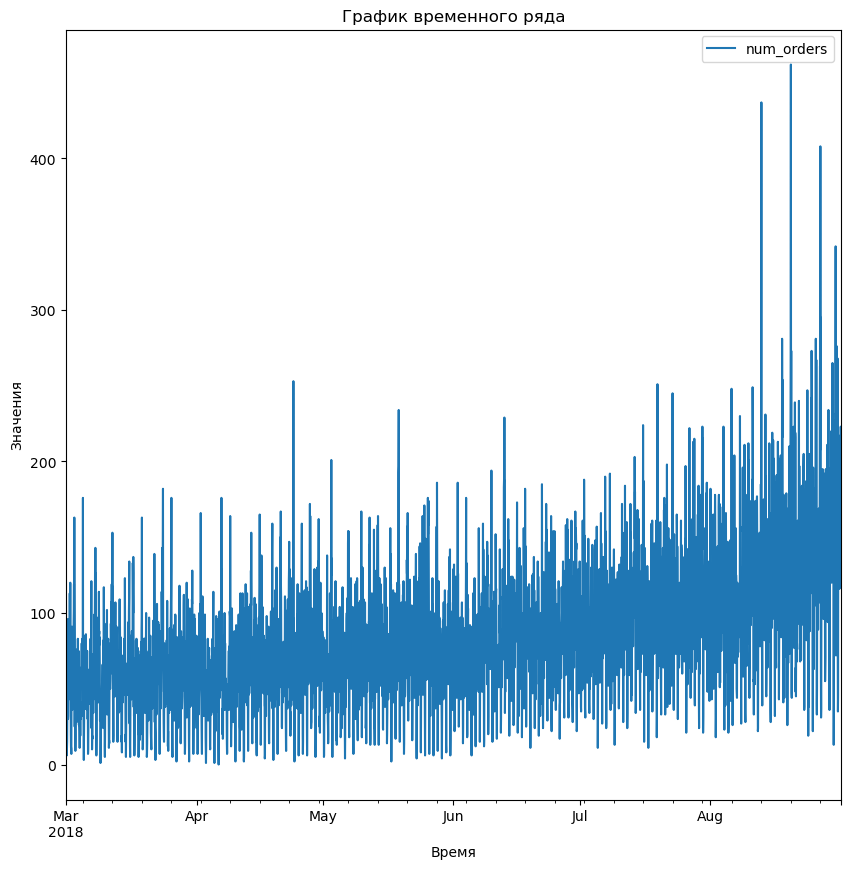

In [8]:
data.plot(figsize=(10, 10))
plt.xlabel('Время')
plt.ylabel('Значения')
plt.title('График временного ряда')
plt.show();

* Рассмотрел данные
* Выполнил ресемплинг по часу

## Анализ

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Отрицательных значений нет.

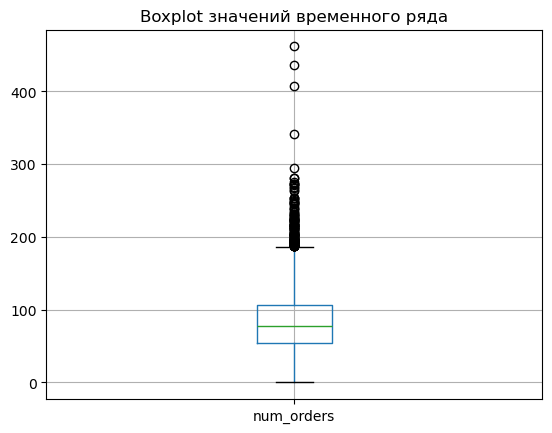

In [10]:
data.boxplot()
plt.title('Boxplot значений временного ряда')
plt.show();

Из графика видно, что основные выбросы за верхней границей.

In [11]:
c = data[data['num_orders']>(data.num_orders.quantile(q=0.75)+
                         1.5*(data.num_orders.quantile(q=0.75)-
                              data.num_orders.quantile(q=0.25)))].count()
print('Количетво выбросов:', c[0])
print('Процентное соотношение выбросов:', round(100*c[0]/data.shape[0], 2))

Количетво выбросов: 121
Процентное соотношение выбросов: 2.74


Выбросов меньше 3%, поэтому оставим их.

In [12]:
print('Начало временного ряда', data.index[0])
print('Конец временного ряда',data.index[data.shape[0]-1])

Начало временного ряда 2018-03-01 00:00:00
Конец временного ряда 2018-08-31 23:00:00


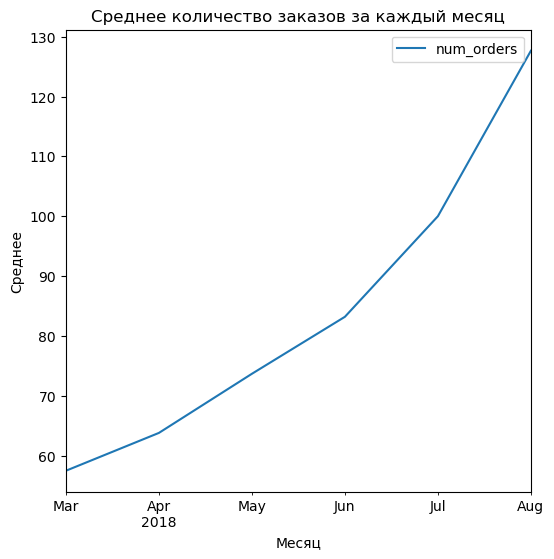

In [13]:
data.resample('1M').mean().plot(figsize=(6, 6))
plt.xlabel('Месяц')
plt.ylabel('Среднее')
plt.title('Среднее количество заказов за каждый месяц')
plt.show();

Из анализа ресемпла по месяцам, видим, что среднее значение возрастает с каждым месяцем.

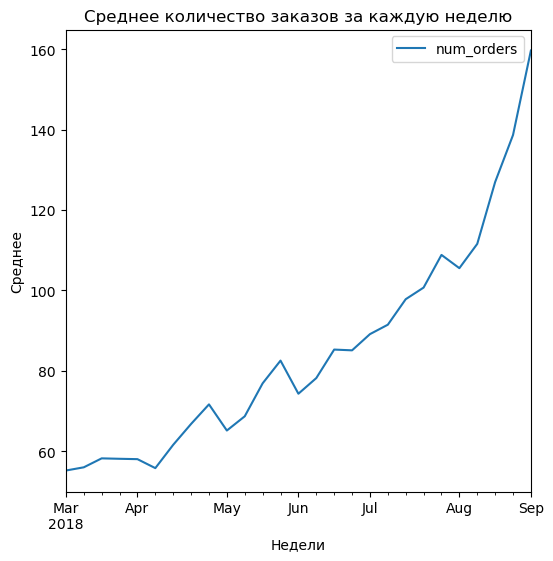

In [14]:
data.resample('1W').mean().plot(figsize=(6, 6))
plt.xlabel('Недели')
plt.ylabel('Среднее')
plt.title('Среднее количество заказов за каждую неделю')
plt.show();

Из анализа за каждую неделю, видим, что
* К концу каждого месяца среднее возрастает
* Месяц начинается со спада предложений
* В августе видим взрыной рост каждую неделю

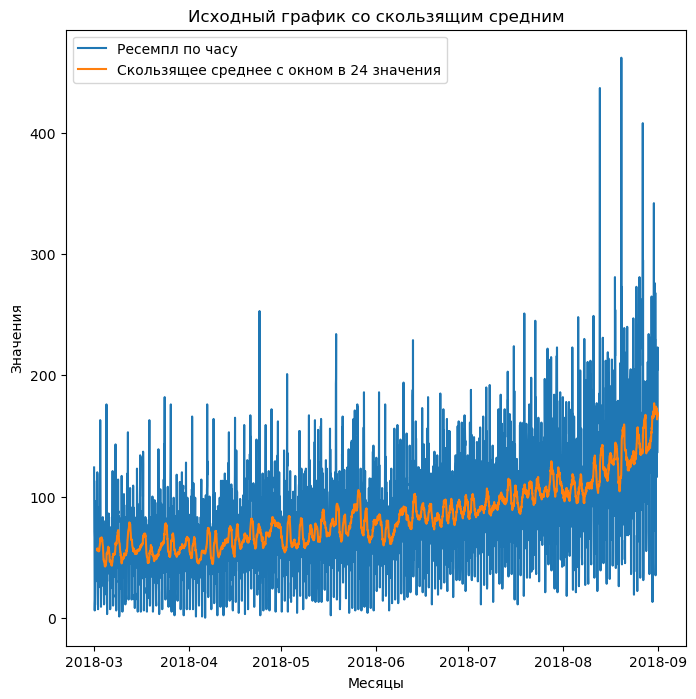

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(data.num_orders, label='Ресемпл по часу')
plt.plot(data.shift().rolling(24).mean(), 
         label='Скользящее среднее с окном в 24 значения')
plt.xlabel('Месяцы')
plt.ylabel('Значения')
plt.title('Исходный график со скользящим средним')
plt.legend()
plt.show();

* Скользящее среднее показывает общую тенденцию к росту.
* К концу периода амплетуда скользящего среднего увеличивается.

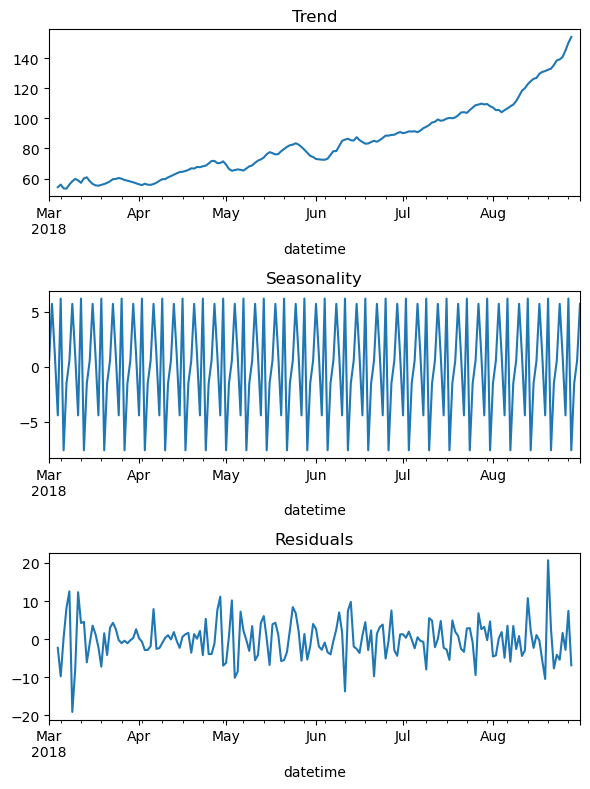

In [16]:
decomposed = seasonal_decompose(data.resample('1D').mean())

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

* Просматривается общий тренд к росту
* Выделяется сезонность
* К концу каждой недели есть скачок
* В августе просматривается рост с ускорением

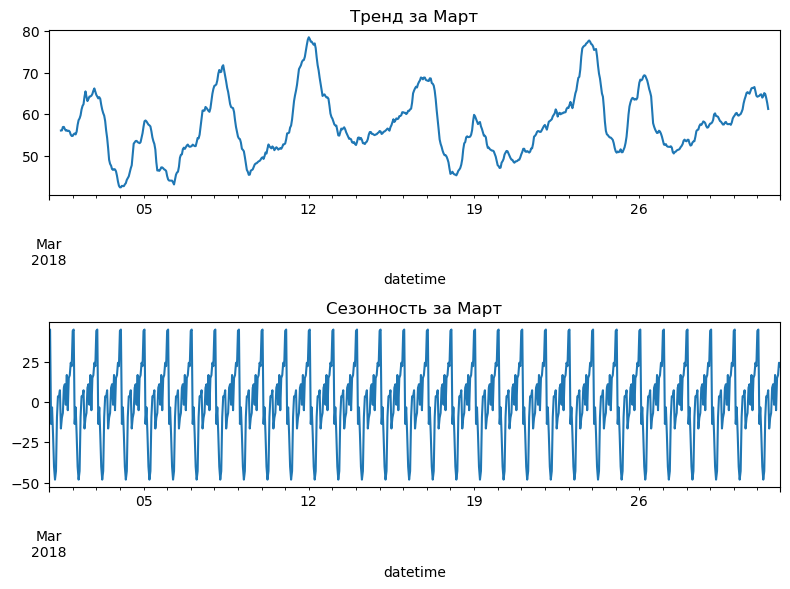

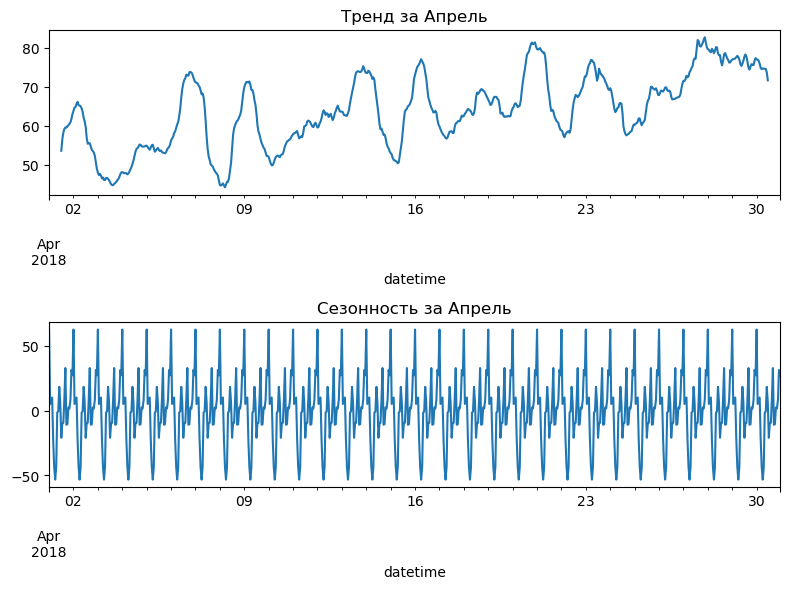

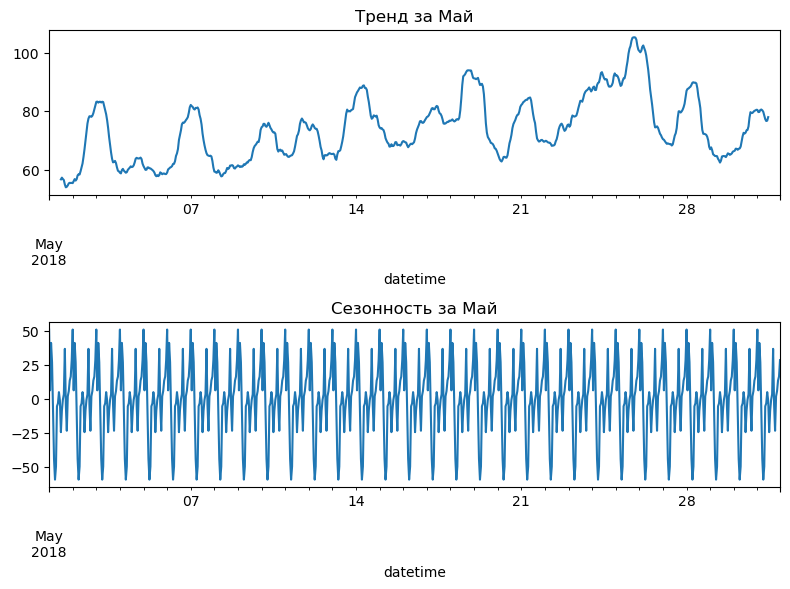

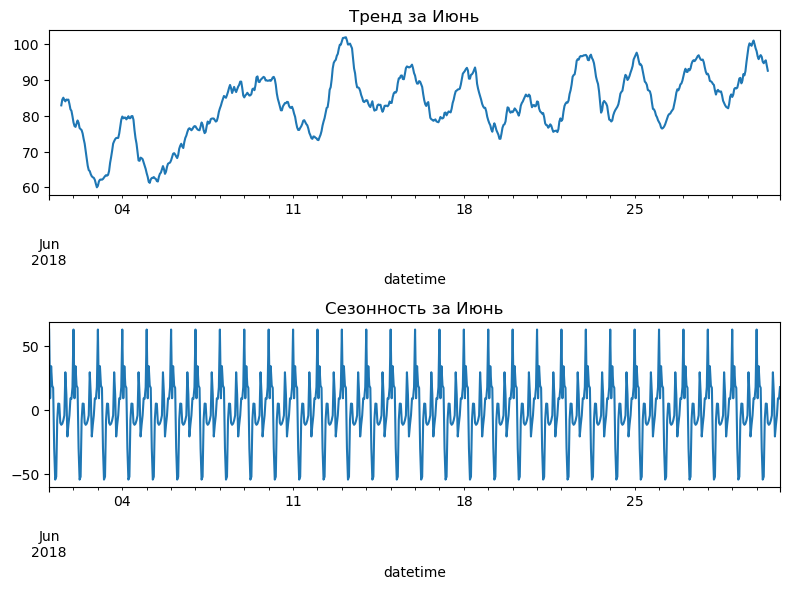

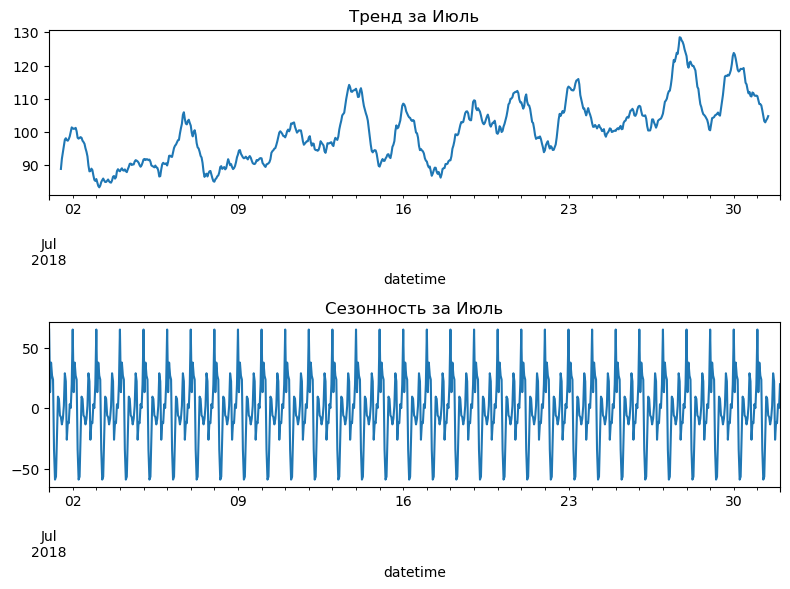

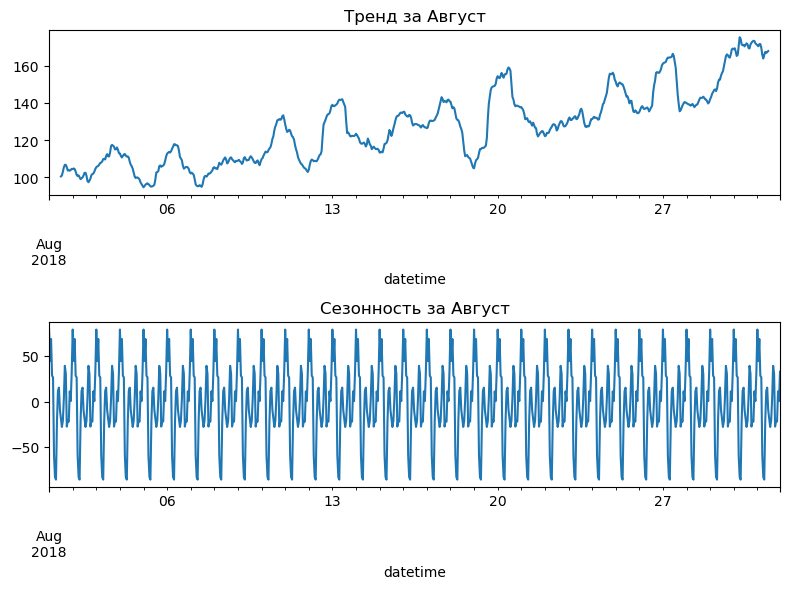

In [17]:
t_period = ['2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08']
mn = ['Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август']
for t in range(len(t_period)):
    decomposed = seasonal_decompose(data.loc[t_period[t]].resample('1H').mean())
    
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'Тренд за {mn[t]}')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(f'Сезонность за {mn[t]}')
    plt.tight_layout()

Чем ближе к концу каждого месяца, тем больше заказов происходит, но общей явной закономерности нет.

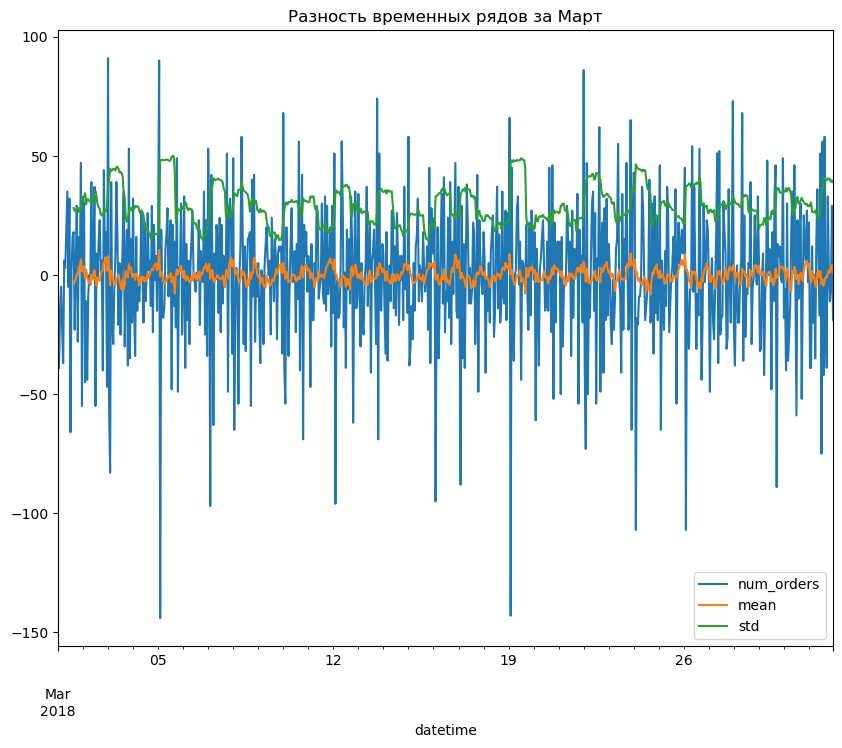

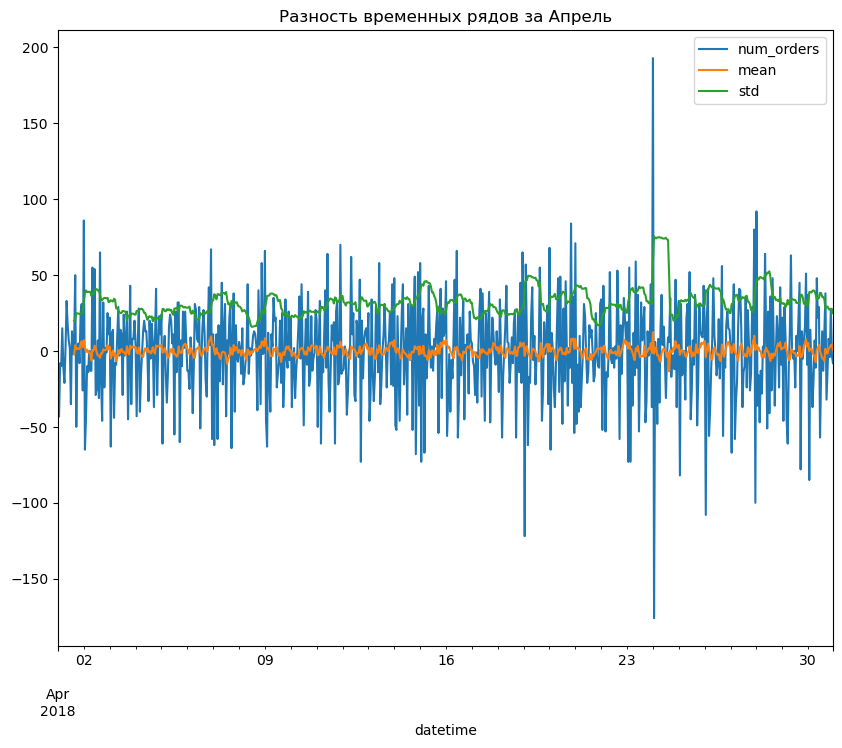

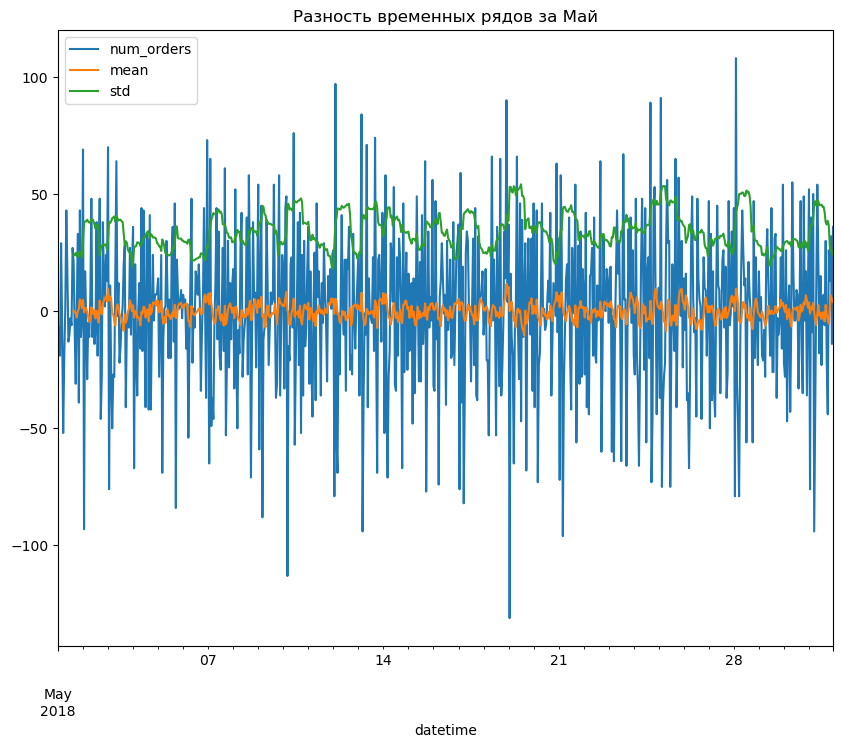

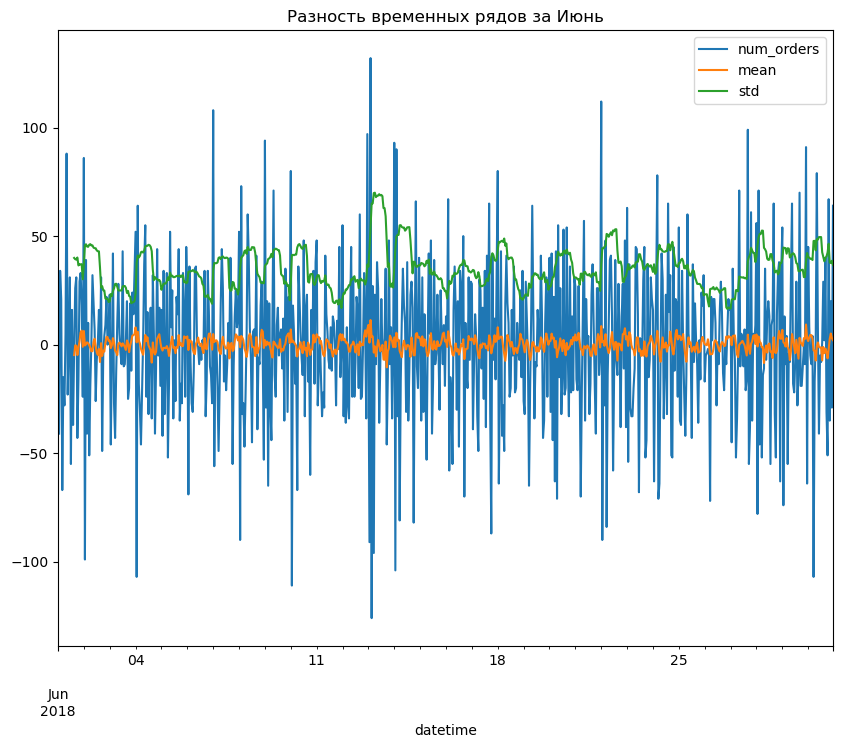

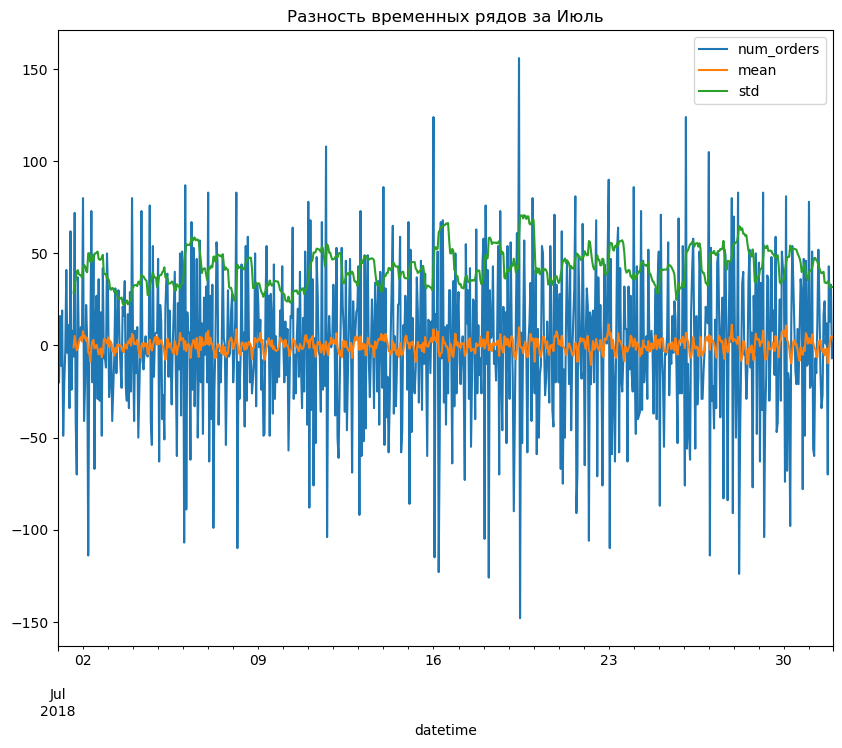

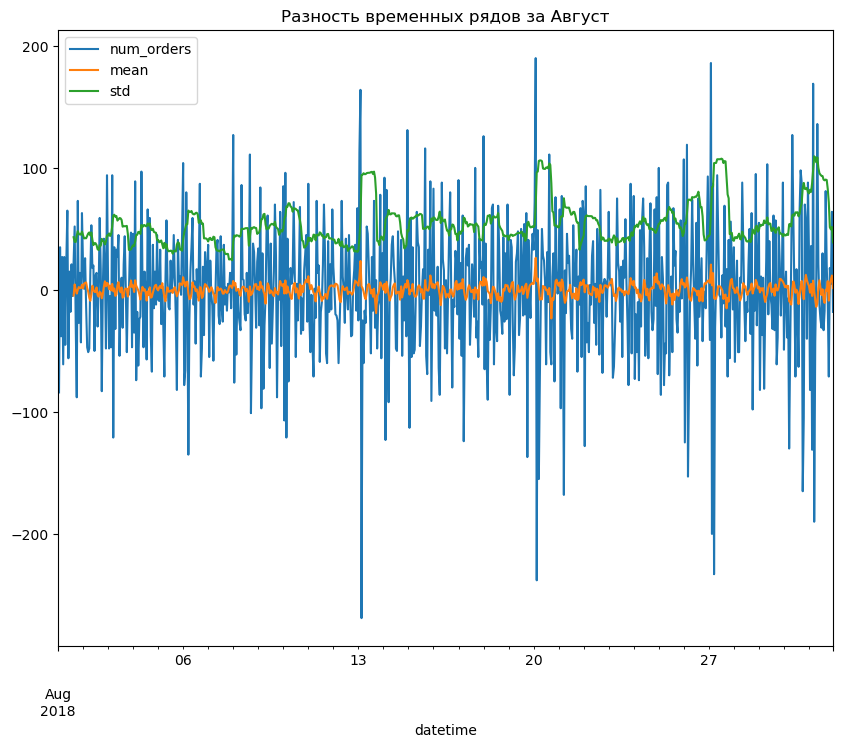

In [18]:
for t in range(len(t_period)):
    df1 = data.loc[t_period[t]]-data.loc[t_period[t]].shift()
    df1['mean'] = df1['num_orders'].rolling(15).mean()
    df1['std'] = df1['num_orders'].rolling(15).std()
    df1.plot(figsize=(10, 8))
    plt.title(f'Разность временных рядов за {mn[t]}')

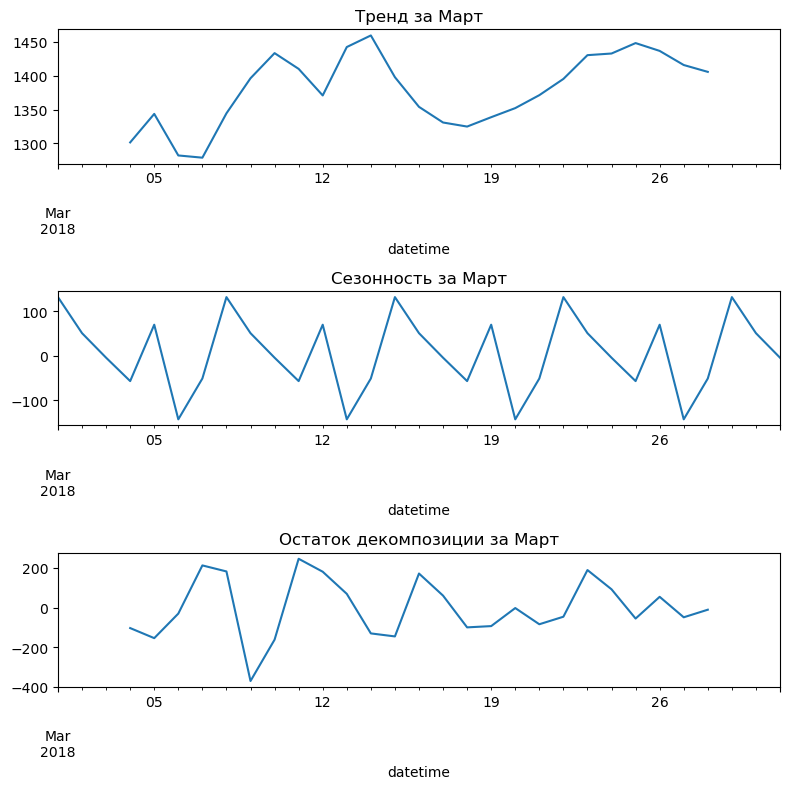

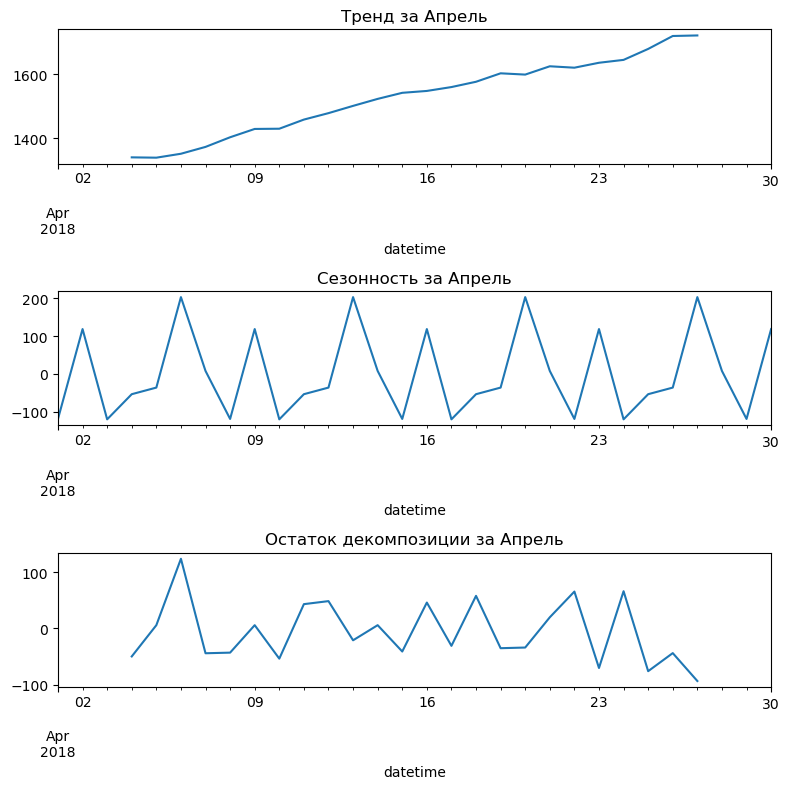

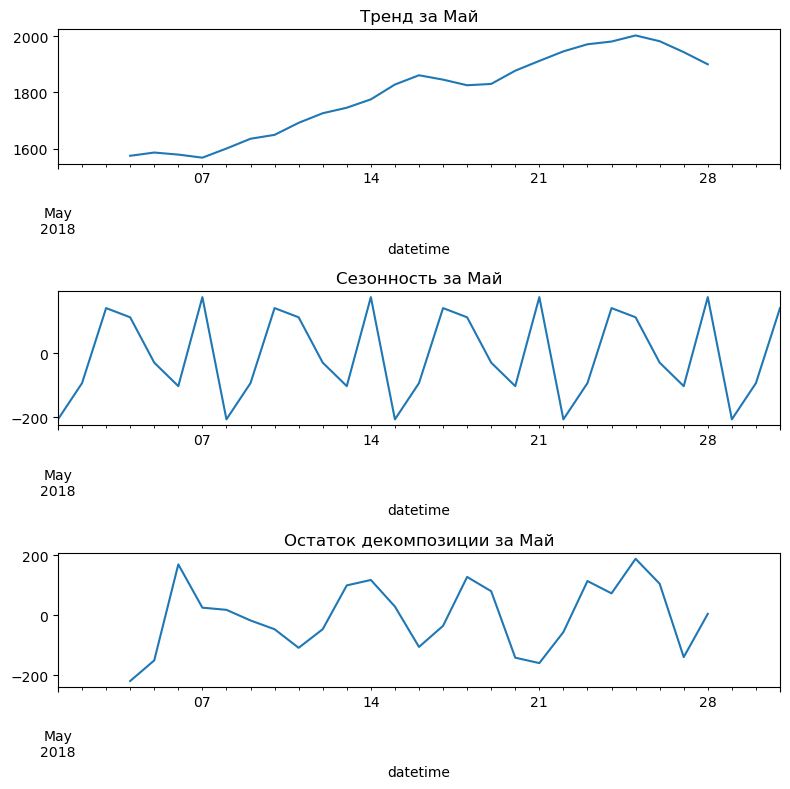

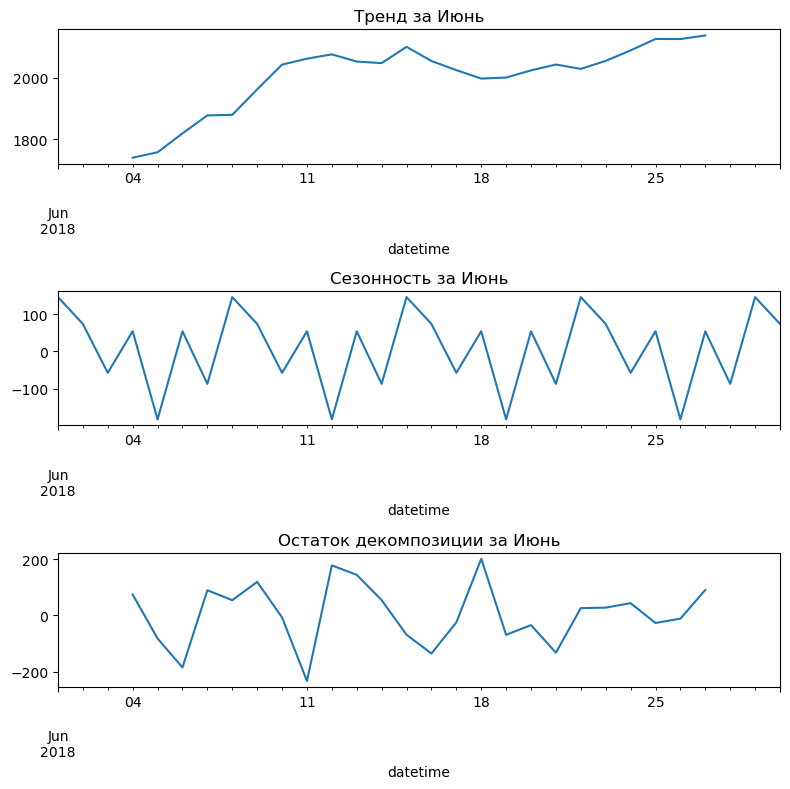

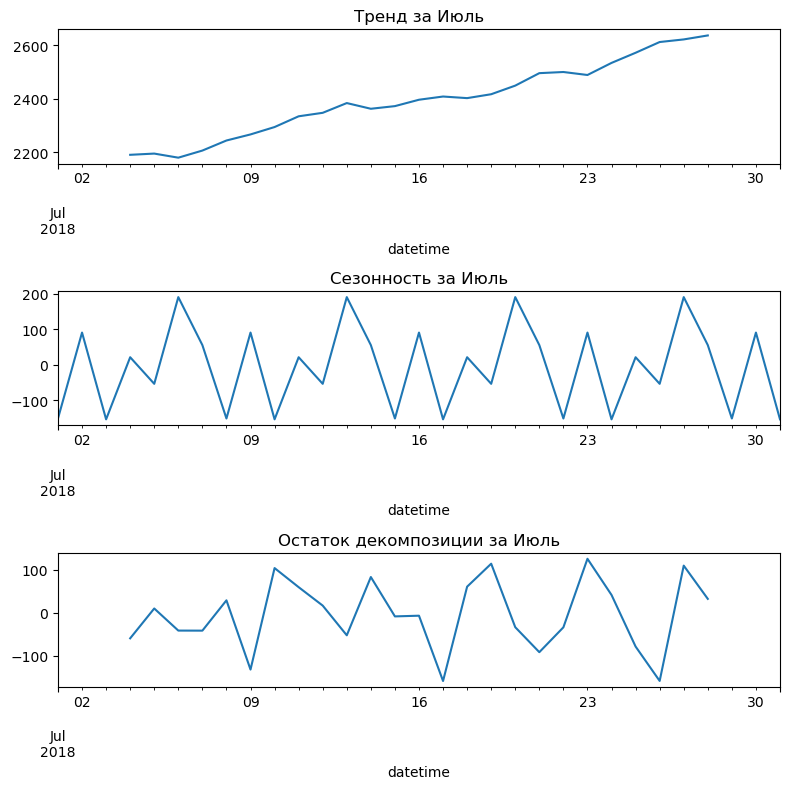

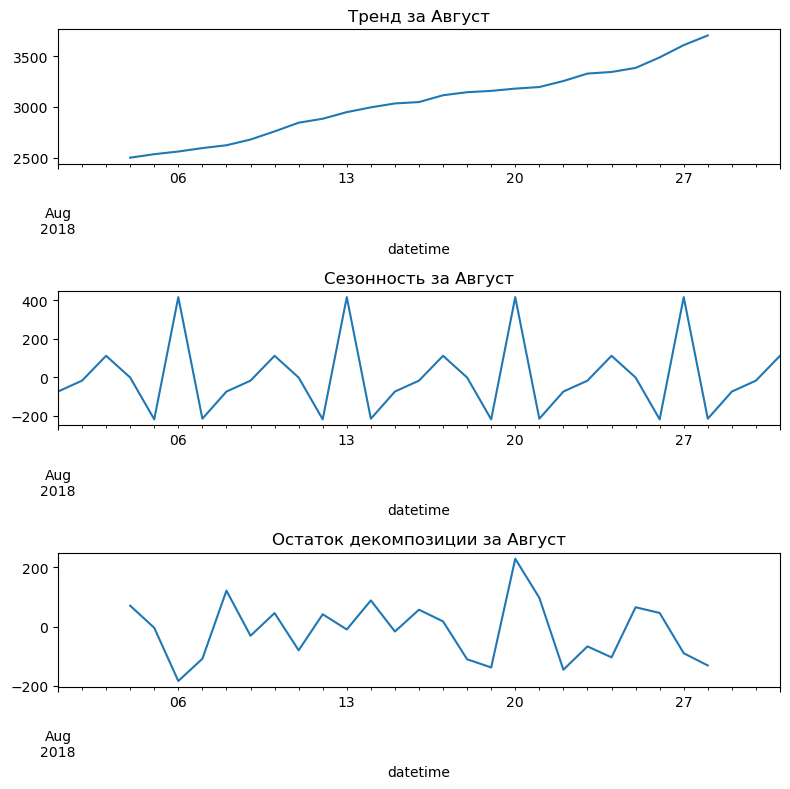

In [19]:
for t in range(len(t_period)):
    decomposed = seasonal_decompose(data.loc[t_period[t]].resample('1D').sum())
    
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'Тренд за {mn[t]}')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(f'Сезонность за {mn[t]}')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title(f'Остаток декомпозиции за {mn[t]}')
    plt.tight_layout()

* Тренды за апрель, июль и август линейно растут

* Остатки за каждый месяц вырастают по модулю, что говорит о появлении сложных для модели данных. Ранее я отмечал рост заказов на конец месяца.

* За каждый месяц на графиках сезонности можно увидеть 4 пика, поэтому следует рассмотреть характеристики за неделю.

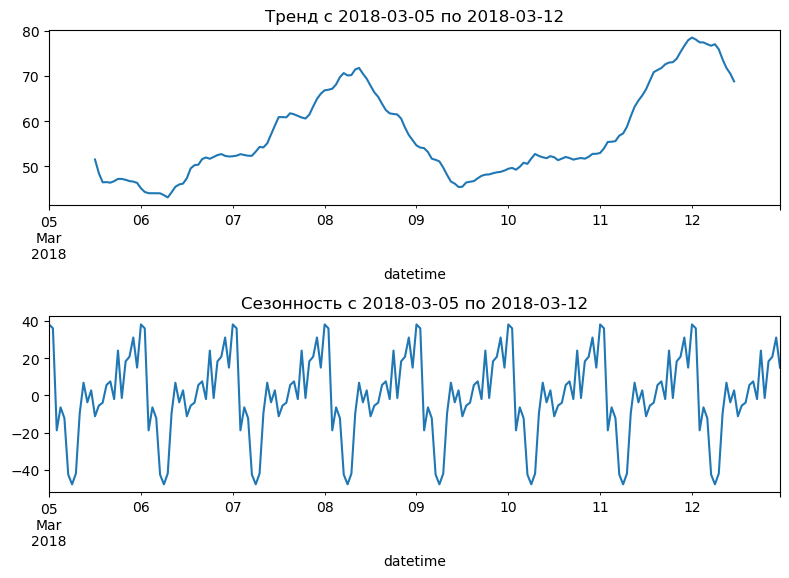

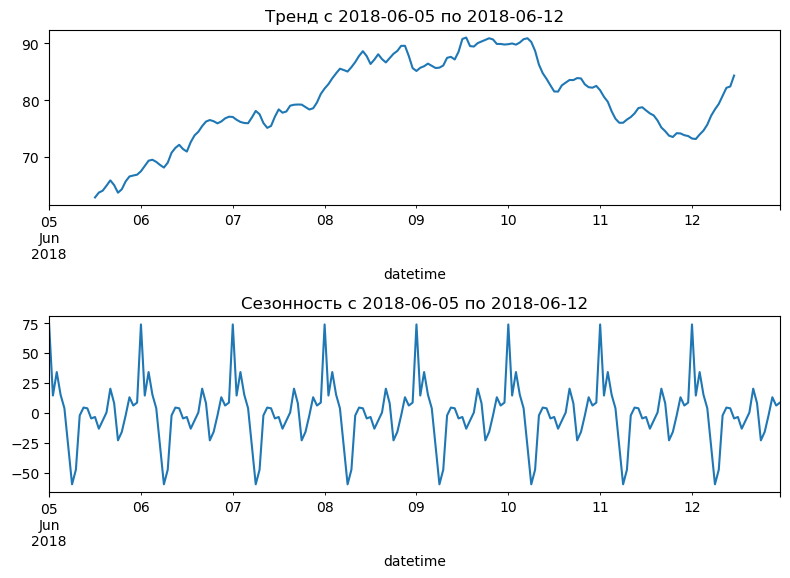

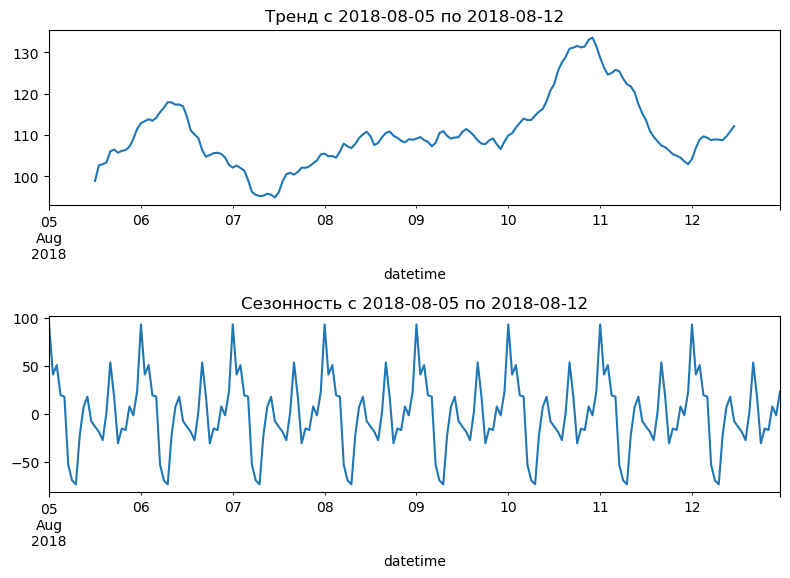

In [20]:
d = ['2018-03-05', '2018-03-12', '2018-06-05','2018-06-12', '2018-08-05','2018-08-12']
df1 = data['2018-03-05':'2018-03-12']
for t in range(0, len(d), 2):
    decomposed = seasonal_decompose(data.loc[d[t]:d[t+1]].resample('1H').sum())
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title(f'Тренд с {d[t]} по {d[t+1]}')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title(f'Сезонность с {d[t]} по {d[t+1]}')
    plt.tight_layout()


Исследование трендов и сезонности по часам за каждый день в течение недель, взятых из марта, июня и августа:

* В каждой из трех недель были горбы, но в марте и августе их выделяется два, тогда как в июне один горб с относительно ровной поверхностью. То есть в течение недели просматривается тренд на повышение в какие-то дни недели.
  
* Что касается сезонности по часам, то во всех трех неделях есть рост в самом начале дня, затем спад, колебания и снова рост к концу дня.

Проведем тест Дики-Фуллера.
Выдвинем гипотезы на проверку стационарности ряда:

H0: Временной ряд нестационарный

H1: Отсутствуют основания утверждать, что ряд нестационарный

In [21]:
test = adfuller(data)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical value:', test[4])

adf: -3.0689242890279482
p-value: 0.028940051402613506
Critical value: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


* Видим, что тестовое значение adf меньше критического на уровне значимости в 5%, то есть можем принимать решение о стационарности
* Однако adf больше критического на уровне значимости 1%, что соответствует нестационарности временного ряда
* Кроме того, значение p-value больше критических, значит мы не можем отвергнуть наличие единичного корня и нестационарности

То есть, можем принять стационарность только на уровне значимости в 5%, НО это не гарантирует, что ряд не является нестационарным.

<font style='font-size:18px; font-weight:bold'>Вывод по разделу</font>

* Отрицательных значений нет, а выбросов меньше 3%. Оставил их.
* Данные представлены с 2018-03-01 00:00:00 до 2018-08-31 23:00:00
* Из анализа ресемпла по месяцам, видно, что есть тенденция к росту.
* К концу каждого месяца среднее возрастает, а начинается со спада предложений.
* В августе видимя взрыной рост каждую неделю, а среднее растет с ускорением.
* Ресемпл по одному дню: Тренды за апрель, июль и август линейно растут.
* Ресемпл по одному дню: Остатки за каждый месяц вырастают по модулю, что говорит о появлении сложных для модели данных.
* Из анализа по часам трех недель из разных месяцев видим, что есть зависимость от дня недели.
* Можем принять стационарность только на уровне значимости в 5%.

## Выбор итоговых признаков

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    #data['weekofmonth'] = data.index.week%4+1
    #data['day'] = data.index.day
    df1 = data.copy()
    df1['dayofweek'] = df1.index.dayofweek
    df1['hour'] = df1.index.hour
    for lag in range(1, max_lag + 1):
        df1['lag_{}'.format(lag)] = df1['num_orders'].shift(lag)
    df1['rolling_mean'] = df1['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df1.dropna()
data1 = make_features(data, 15, 11)
data1.head(5)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 15:00:00,66,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,40.818182
2018-03-01 16:00:00,43,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.909091
2018-03-01 17:00:00,44,3,17,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,46.272727
2018-03-01 18:00:00,73,3,18,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,49.181818
2018-03-01 19:00:00,45,3,19,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,54.454545


Добавил новые признаки день недели, час, а также смещения вплоть до 15-го и скользящее среднее с промежутком в 11 значения. Данный выбор был сделан эмпирическим перебором.

## Выбор наилучшей модели

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data1.drop('num_orders', axis=1),data1.num_orders,
                               shuffle=False, test_size=0.1)
print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

2018-03-01 15:00:00 2018-08-13 14:00:00
2018-08-13 15:00:00 2018-08-31 23:00:00
(3960, 18)
(3960,)
(441, 18)
(441,)


Разбил выборку 9:1, учитывая, что не так много данных для обучения.

In [24]:
#Функция для mse
scoring = {
    'mse': make_scorer(mean_squared_error) 
}

Для подбора гиперпараметров использовал GridSearch с кросс-валидацией.

In [25]:
dum = DummyRegressor()
dum.fit(X_train, y_train)
preds = dum.predict(X_test)
print('rmse:', mean_squared_error(y_test, preds)**0.5)

rmse: 84.75907688394722


Константная модель дала плохой результат, его можно улучшить более сложными моделями.

In [26]:
lasso = GridSearchCV(Lasso(), 
                    {'alpha': [0.01, 0.1, 1, 2],
                     'selection': ['cyclic', 'random'],
                     'tol': [1e-4, 1e-6]}, cv=TimeSeriesSplit(),
                    scoring=scoring, refit='mse')
lasso.fit(X_train, y_train)
print(lasso.best_params_)
print('rmse', lasso.best_score_**0.5)

{'alpha': 0.1, 'selection': 'random', 'tol': 1e-06}
rmse 32.56274959398743


Первую модель взял линейную Lasso. Подбирал три гиперпараметра. Даже простая модель дала лучше результат.

In [27]:
rfr = GridSearchCV(RandomForestRegressor(random_state=st), 
                   {'n_estimators': [170, 175, 200],
                    'max_depth': range(15, 19),
                    'max_features': ['sqrt', 'log2']},
                   cv=TimeSeriesSplit(n_splits=4),
                  scoring=scoring, refit='mse')
rfr.fit(X_train, y_train)
print(rfr.best_params_)
print('rmse', rfr.best_score_**0.5)

{'max_depth': 18, 'max_features': 'sqrt', 'n_estimators': 170}
rmse 27.527619848049248


Использовал лес, подбирал количество деревьев, максимальную глубину и критерий разбиения.

In [28]:
xgb = XGBRegressor(silent=True, n_estimators=800)
params = {
        'depth': [10, 12, 14],
        'learning_rate': [0.03, 0.05]
        }

CV_xgb = GridSearchCV(xgb, param_grid=params, cv=TimeSeriesSplit(n_splits=4),
                  scoring=scoring, refit='mse');
CV_xgb.fit(X_train, y_train);
print(CV_xgb.best_params_)
print('rmse', CV_xgb.best_score_**0.5)

{'depth': 10, 'learning_rate': 0.05}
rmse 26.566233294043283


Бустинговая модель XGB дала наилучший результат.

In [30]:
cat = GridSearchCV(CatBoostRegressor(random_state=st, verbose=False, learning_rate=.005),
                   {'iterations' : [500, 600, 700],
                    'depth' : [10, 12, 14]},
                   scoring=scoring, refit='mse')
cat.fit(X_train, y_train)
print(cat.best_params_)
print('rmse', cat.best_score_**0.5)

{'depth': 14, 'iterations': 500}
rmse 28.153410989331004


Использовал бустинговую модель CatBoostRegressor, подбирал число итераций и глубину деревьев. Она показала результат хуже.

Лучший результат показал XGB с лучшей метрикой 26.56.

## Тестирование

Предскажем количество заказов для тестовых данных.

In [33]:
preds = CV_xgb.best_estimator_.predict(X_test)
print('rmse:', mean_squared_error(y_test, preds)**0.5)

rmse: 44.564292158089586


Итоговая оценка получилась лучше требуемой (rmse=48).

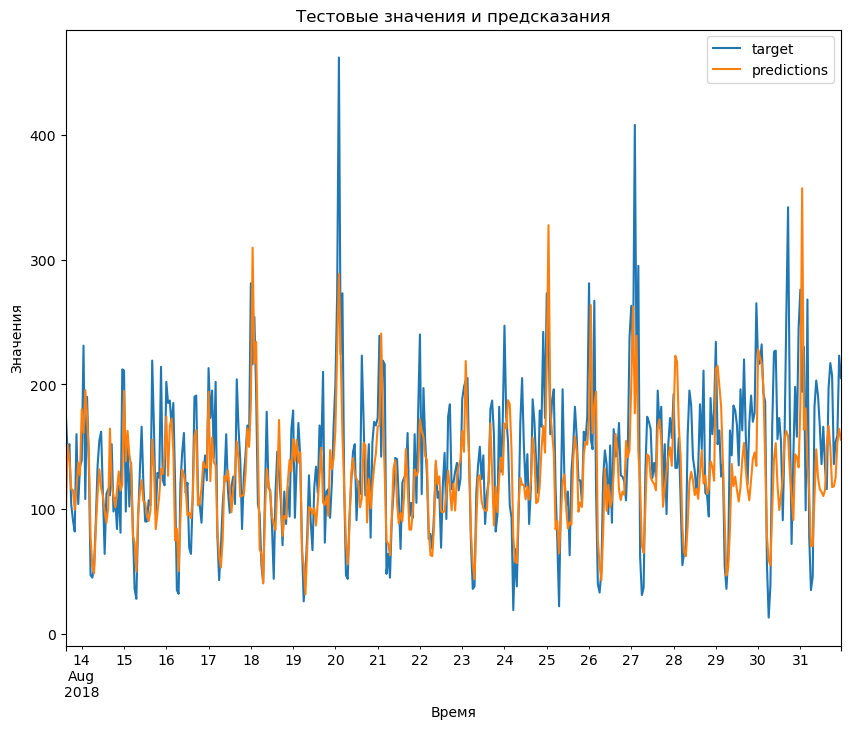

In [34]:
df1 = pd.DataFrame()
df1['target'] = y_test
df1['predictions'] = preds
df1.plot(figsize=(10, 8))
plt.xlabel('Время')
plt.ylabel('Значения')
plt.title('Тестовые значения и предсказания')
plt.show();

Построил график значений и предсказаний, как видно, модель лучше предсказывает спады, чем скочки.

## Вывод

***Знакомство с данными***
   
   - *Загрузка данных*
   
   - *Сделал первичный анализ данных, проверил хронологичность.*
   
   - *Сделал ресемплирование по часу*
    
***Анализ данных***
   
   - *Рассмотрел количество выбросов, их оказалось меньше 3%, оставил выбросы нетронутыми.*

   - *Рассмотрел средние значения, виден рост с ускорением в августе.*
   
   - *Рассмотрел данные со скользящим средним. Выделил, что есть тенденция к увеличению заказов с каждым месяцем.*
    
   - *Рассмотрел сезонность и тренды, наблюдается скачок в конце каждой недели, а так же в каждой последней неделе месяца. В начале месяца обычно спад.*
   
   - *Провел тест Дики — Фуллера, стационарным ряд можно считать только при уровне значимости 5%.*
   
   - *Добавил новые признаки, исходя из анализа* 
 
***Обучение***

   - *Метрика для оценки моделей - среднеквадратичная ошибка.*

   - *Разбил данные на тестовую и тренировочную выборки.*
   
   - *Использовал GridSearchCV с кросс-валидацией для подбора гиперпараметров.*

   - *Dummy модель дала метрику на тесте rmse=84.75*
   
   - *Рассмотрел Lasso, лучшая метрика на кросс-валидации rmse=32.56*
 
   - *Рассмотрел RandomForestRegressor, лучшая метрика на кросс-валидации rmse=27.5*

   - *Рассмотрел XGBRegressor, модель дала лучшую метрику на кросс-валидации rmse=26.56*

   - *Рассмотрел CatBoostRegressoк, лучшая метрика на кросс-валидации rmse=28.15*
   
***Тестирование*** 
   
   - *XGBRegressor дал метрику на тестовых данных rmse=44.5<48*
   

*Таким образом, я проанализировал временной ряд, выделил закономерности и обучил модель для предсказания количества заказов такси на следующий час.*